In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys

import itertools

import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.units import units
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from metpy import constants

from skimage.measure import label, regionprops

phys_table = [1,2,7,8,13,14, 3,4,9,10,15,16, 5,6,11,12,17,18]

#                 YSU              MYJ              MYNN

phys_table = [x-1 for x in phys_table]

print(phys_table)

storm_size = [10, 120]

lats = [35.294243, 43.726334]
lons = [-92.01535, -80.48016]


[0, 1, 6, 7, 12, 13, 2, 3, 8, 9, 14, 15, 4, 5, 10, 11, 16, 17]


In [2]:
import datetime
#--------------------------------------------------------------------------------------------------
# my datetime stuff
def my_datetime(input: list, time_delta=None, format=None, summary_file=False):

    """
        Inputs: input (list) list of [YY, MM, DD, HH, MM, SS]

                time_delta: (list)  -> [hours, minutes, seconds]
                                
                                or
                                    ->  [Days, hours, minutes, seconds]
                                    
                format:  (string)   ->  '%Y-%m-%d::%H-%M'
                
                                or
                                    ->  '%Y%d_%H%M'  (usefull for WoFS files)

        returns:  Datetime object or string if format is supplied.
        
    """
    try:
        hhmm = datetime.datetime(*input)
    except ValueError:
        print(f"Input is invalid, need YYMMDDHHMM {input}")
        return None
        
    if time_delta == None:
        
        if format == None:
            return hhmm
        else:
            return hhmm.strftime(format)
    
    else:
        
        if len(time_delta) == 3:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2])
        else:
            timeD = datetime.timedelta(days=time_delta[0], hours=time_delta[1], minutes=time_delta[2], seconds=time_delta[3])
            
        if format == None and summary_file == False:
            
            return hhmm + timeD
            
        else:
            
            if summary_file:

                return f"{hhmm.strftime('%Y%m%d_%H%M')}_{(hhmm+timeD).strftime('%H%M')}"

            else:  
                return (hhmm+timeD).strftime(format)

print( my_datetime([2024,5,7,19], time_delta=[0,0,65]) )
print( my_datetime([2024,5,7,19], time_delta=[0,0,65], summary_file=True ))

2024-05-07 20:05:00
20240507_1900_2005


In [3]:
# New section to "count" storms

def get_counts(ds, ens, cref_thresh =[25,], storm_size = storm_size, field_name='comp_dz'):

    if ens == 1:

        regions = []

        mask_cref = np.where(ds[field_name] >= cref_thresh[0], True, False)

        f_mask = mask_cref.astype(np.int8)

        mpas_label_array, counts = label(f_mask, connectivity=2, return_num = True)
        
        # Calculate region properties
        
        for l, props in enumerate(regionprops(mpas_label_array)):
                regions.append(props.area)

    else:
            
        counts = np.zeros( (ens,), dtype='int')
        
        mask_cref = np.where(ds[field_name] > cref_thresh[0], True, False)

        f_mask = mask_cref.astype(np.int8)

        regions = []

        for n in np.arange(ens):

            mpas_label_array, counts[n] = label(f_mask[n], connectivity=2, return_num = True)

            # Calculate region properties
        
            for l, props in enumerate(regionprops(mpas_label_array)):
                regions.append(props.area)

    return counts, regions


In [35]:
def find_percentile(runs, dt_string, title, ens=18, nstep=25, skip=0, percentile=[25,50], plot_mrms=None):
                
    time = 5*np.arange(nstep)

    ret_percentile = []

    for r, run in enumerate(runs):
    
        print(f"Now computing stats for {run[0]}\n")

        big_list = []

        for n in np.arange(nstep):
    
            min = int(n*5)
        
            file_string = my_datetime(dt_string, time_delta=[0,0,min], summary_file=True)
                    
            ds = xr.open_dataset(os.path.join(run[0], f"wofs_ALL_{n:02}_{file_string}.nc"))

            big_list.append(ds['comp_dz'].values.flatten())

        big_list = list(itertools.chain.from_iterable(big_list))

        big_array = np.asarray(big_list).flatten()

        big_array = big_array[big_array > 0.1]

        print(f"Shape of array:  {big_array.shape}")

        sorted = np.sort(big_array)

        for p in percentile:
            print(f"Max value:  {big_array.max()}  Min value:  {big_array.min()}")
            idx = int(p/100. * big_array.shape[0])

            print(f"Percentile: {p} Index:  {idx}   Value:  {sorted[idx]}\n")

            ret_percentile.append({'percentile': p, 'index': idx, 'value': sorted[idx], 'run': run})
        
    # if plot_mrms:

    #     with open(plot_mrms, 'rb') as file:
    #         data = pickle.load(file)
            
    #     axs[0].plot(data['time'], data['pixels'], linestyle='--', color='k', label='MRMS')
    #     # axs[1].hlines(xmin=0, xmax=17, y=data['objects'].mean(), linestyle='--', color='k', label='MRMS')

    # # axs[2].set_title(title, fontsize=10)
    # # axs[2].set_xlabel('Forecast time in minutes')
    # # axs[2].set_ylabel('Pixel Count')
    # # axs[2].set_ylim(1000,3000)
    # # axs[2].legend();

    # axs[0].set_title(title, fontsize=10)
    # axs[0].set_xlabel('Forecast time in minutes')
    # axs[0].set_ylabel(f'PIXELS COUNT')
    # axs[0].set_ylim(0,200)
    # axs[0].legend();

    # axs[1].set_title(title, fontsize=10)
    # axs[1].set_xlim(0,17)
    # axs[1].set_ylim(0000,200)
    # yrange = axs[1].get_ylim()
    # axs[1].vlines(x=5,  ymin=yrange[0], ymax=yrange[1], colors='k', alpha = 0.25)
    # axs[1].vlines(x=11, ymin=yrange[0], ymax=yrange[1], colors='k', alpha = 0.25)
    # new_ticks  = [3, 8, 13]
    # new_labels = ['YSU', 'MYJ', 'MYNN']
    # axs[1].set_xticks(new_ticks)
    # axs[1].set_xticklabels(new_labels)
    # axs[1].set_xlabel('ENS MEMBERS')
    # axs[1].set_ylabel(f'PIXELS COUNT')
    # axs[1].legend()

    # fig, axs = plt.subplots(1, len(runs), tight_layout=True, figsize=(15,5))

    # bins = [10,25,50,100,125,150,200,300,400,500,750]
    # # bins = [10,25,50,100,125,150,200,300,400]

    # for r, run in enumerate(runs):
    #     axs[r].hist(regions[r], bins=bins, edgecolor='k', label=run[1])
    #     axs[r].set_ylim(1,13000)
    #     axs[r].set_xlim(0,bins[-1])
    #     axs[r].hist(data['area'],bins=bins, edgecolor='k', label='MRMS')
    #     axs[r].legend()
    #     axs[r].set_yscale('log', nonpositive='clip')
    #     axs[r].set_xlabel('AREA in 3KM Pixels')
    #     axs[r].set_ylabel(f'LOG of FREQUENCY')
    #     axs[r].set_title(title[-14:], fontsize=10)

    return ret_percentile

In [37]:
nstep = 25
ens   = 18
cref_thresh = [25,]

runs  = [
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/1900','MPAS KM', 'b'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/1900','MPAS KM2', 'r'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/1900','MPAS NCAR', 'c'],
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/1900', 'WRF-DART CNTL', 'g']
        ]

title = f"WRF / MPAS / MRMS {cref_thresh[0]} DBZ CREF PIXELS 1900-2100 UTC"

dt_string = [2024,5,7,19]

p1900 = find_percentile(runs, dt_string, title, ens=18, nstep = 25, percentile=[90,95,99])

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/1900

Length of comp_dz list:  25
Shape of array:  (13978931,)
Max value:  74.703125  Min value:  0.100006103515625
Percentile: 90 Index:  12581037   Value:  34.90625

Max value:  74.703125  Min value:  0.100006103515625
Percentile: 95 Index:  13279984   Value:  41.546875

Max value:  74.703125  Min value:  0.100006103515625
Percentile: 99 Index:  13839141   Value:  52.0625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/1900

Length of comp_dz list:  25
Shape of array:  (13896736,)
Max value:  70.5625  Min value:  0.100006103515625
Percentile: 90 Index:  12507062   Value:  34.828125

Max value:  70.5625  Min value:  0.100006103515625
Percentile: 95 Index:  13201899   Value:  41.515625

Max value:  70.5625  Min value:  0.100006103515625
Percentile: 99 Index:  13757768   Value:  51.9375

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/190

In [39]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18

runs  = [
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/2000','MPAS KM', 'b'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2000','MPAS KM2', 'r'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2000','MPAS NCAR', 'c'],
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2000', 'WRF-DART CNTL', 'g']
        ]


title = f"WRF / MPAS / MRMS {cref_thresh[0]} DBZ CREF PIXELS 2000-2200 UTC"

dt_string = [2024,5,7,20]
p2000 = find_percentile(runs, dt_string, title, ens=18, nstep = 25, percentile=[90,95,99])

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/2000

Length of comp_dz list:  25
Shape of array:  (12877290,)
Max value:  70.703125  Min value:  0.100006103515625
Percentile: 90 Index:  11589561   Value:  35.875

Max value:  70.703125  Min value:  0.100006103515625
Percentile: 95 Index:  12233425   Value:  42.46875

Max value:  70.703125  Min value:  0.100006103515625
Percentile: 99 Index:  12748517   Value:  52.765625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2000

Length of comp_dz list:  25
Shape of array:  (12892978,)
Max value:  71.625  Min value:  0.10009765625
Percentile: 90 Index:  11603680   Value:  35.859375

Max value:  71.625  Min value:  0.10009765625
Percentile: 95 Index:  12248329   Value:  42.46875

Max value:  71.625  Min value:  0.10009765625
Percentile: 99 Index:  12764048   Value:  52.9375

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2000

Length of comp

In [40]:
#------------------------------------------------------------------------------------
nstep = 25
ens   = 18

runs  = [
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/2100','MPAS KM', 'b'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2100','MPAS KM2', 'r'],
         ['/scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2100','MPAS NCAR', 'c'],
         ['/work2/Thomas.Jones/POST/summary_files/20240507_CTL_V3/2100', 'WRF-DART CNTL', 'g']
        ]
title = f"WRF / MPAS / MRMS {cref_thresh[0]} DBZ CREF PIXELS 2100-2300 UTC"

dt_string = [2024,5,7,21]

p2100 = find_percentile(runs, dt_string, title, ens=18, nstep = 25, percentile=[90,95,99])

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM/2100

Length of comp_dz list:  25
Shape of array:  (11652724,)
Max value:  69.109375  Min value:  0.100006103515625
Percentile: 90 Index:  10487451   Value:  37.21875

Max value:  69.109375  Min value:  0.100006103515625
Percentile: 95 Index:  11070087   Value:  44.03125

Max value:  69.109375  Min value:  0.100006103515625
Percentile: 99 Index:  11536196   Value:  53.421875

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmKM2/2100

Length of comp_dz list:  25
Shape of array:  (11655972,)
Max value:  69.8125  Min value:  0.100006103515625
Percentile: 90 Index:  10490374   Value:  37.4375

Max value:  69.8125  Min value:  0.100006103515625
Percentile: 95 Index:  11073173   Value:  44.1875

Max value:  69.8125  Min value:  0.100006103515625
Percentile: 99 Index:  11539412   Value:  53.625

Now computing stats for /scratch/wofs_mpas/run_dirs/summary_files/20240507_5kmncar/2100

L

In [2]:
def get_sorted_files(directory, pattern):
  """
  Gets a list of files in a directory matching a wildcard pattern, 
  sorts them alphabetically, and returns the sorted list.

  Args:
    directory: The path to the directory to search.
    pattern: The wildcard pattern to match (e.g., "*.txt", "image*").

  Returns:
    A list of sorted file names that match the pattern, or an empty list if 
    no files match or the directory doesn't exist.
  """
  try:
      
    return sorted( glob.glob(os.path.join(directory, pattern)) )

  except FileNotFoundError:
    return []

In [6]:
# MRMS

directory = "/work/wicker/MPAS_WRF_W/MRMS_20240507/1900/"
pattern    = "MRMS_MergedReflectivityQComposite_00.50_20240507-*.grib2"

files = get_sorted_files(directory, pattern)

nstep = len(files)
dt    = 120 / nstep

time = dt*np.arange(nstep)

big_list = []
ret_percentile = []

for n, file in enumerate(files):

    if (n % 10 ) == 0:
        print(f"Now computing stats for {file}\n")
            
    ds = xr.open_dataset(file, engine='cfgrib')

    cropped_ds = ds.sel(latitude=slice(lats[1],lats[0]), longitude=slice(lons[0]+360,lons[1]+360))

    cropped_ds2 = cropped_ds.coarsen(latitude=3,boundary='trim').mean().coarsen(longitude=3,boundary='trim').median()
    
    big_list.append(cropped_ds2['unknown'].values.flatten())

big_list = list(itertools.chain.from_iterable(big_list))

big_array = np.asarray(big_list).flatten()

big_array = big_array[big_array > 0.1]

print(f"Shape of array:  {big_array.shape}")

lsorted = np.sort(big_array)

for p in [90,95,99]:
    print(f"Max value:  {big_array.max()}  Min value:  {big_array.min()}")
    idx = int(p/100. * big_array.shape[0])

    print(f"Percentile: {p} Index:  {idx}   Value:  {lsorted[idx]}\n")

    ret_percentile.append({'percentile': p, 'index': idx, 'value': lsorted[idx]})        

ds.close()



Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240507/1900/MRMS_MergedReflectivityQComposite_00.50_20240507-190040.grib2

Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240507/1900/MRMS_MergedReflectivityQComposite_00.50_20240507-192041.grib2

Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240507/1900/MRMS_MergedReflectivityQComposite_00.50_20240507-194035.grib2

Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240507/1900/MRMS_MergedReflectivityQComposite_00.50_20240507-200040.grib2

Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240507/1900/MRMS_MergedReflectivityQComposite_00.50_20240507-202241.grib2

Now computing stats for /work/wicker/MPAS_WRF_W/MRMS_20240507/1900/MRMS_MergedReflectivityQComposite_00.50_20240507-204240.grib2

Shape of array:  (1008723,)
Max value:  69.93333435058594  Min value:  0.13333332538604736
Percentile: 90 Index:  907850   Value:  40.46666717529297

Max value:  69.93333435058594  Min value:  0.13333332538604736
Percent

In [208]:
mrms_data = {'time': time, 'pixels': mrms_counts, 'area': mrms_regions}

# Pickling (serialization)
with open('mrms1900_45.pickle', 'wb') as file:
    pickle.dump(mrms_data, file)


In [37]:
mrms_regions

array([104, 101, 102, 102,  99,  91,  91,  94,  95,  90,  97, 106,  96,
       103,  98,  97, 101,  93,  93,  84,  88,  90,  91,  88,  96,  97,
        92,  94,  98,  92,  85, 100,  95,  98, 103, 104, 105, 101, 105,
        99, 102,  94,  87,  91,  85,  81,  93,  90,  88,  79,  76,  78,
        80,  74,  81,  81,  87,  83,  89,  93])

(array([ 2.,  3.,  4.,  3.,  6., 13.,  7.,  8.,  7.,  7.]),
 array([ 74. ,  77.2,  80.4,  83.6,  86.8,  90. ,  93.2,  96.4,  99.6,
        102.8, 106. ]),
 <BarContainer object of 10 artists>)

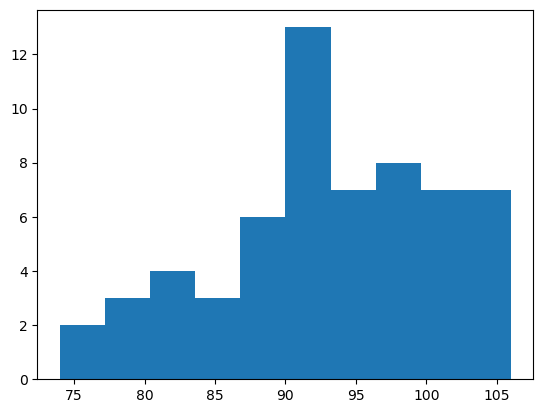

In [32]:
plt.hist(mrms_regions)

In [17]:
print(ds.XLAT.max())
print(ds.XLAT.min())
print(ds.XLONG.max())
print(ds.XLONG.min())

<xarray.DataArray 'XLAT' ()> Size: 4B
array(43.726334, dtype=float32)
<xarray.DataArray 'XLAT' ()> Size: 4B
array(35.294243, dtype=float32)
<xarray.DataArray 'XLONG' ()> Size: 4B
array(-80.48016, dtype=float32)
<xarray.DataArray 'XLONG' ()> Size: 4B
array(-92.01535, dtype=float32)


In [26]:
print(lons)

[-92.01535, -80.48016]
